In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy

In [2]:
Msun=cte.M_sun
c=cte.c

In [3]:
ref= (c/(100*un.um)).to("GHz")
print(ref)

2997.9245800000003 GHz


In [4]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [5]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=c/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [6]:
frecs0T=[v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]]
errf0T=[ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]]

In [7]:
frecs0=np.array([[v1[0],v2[0],v3[0]],[l1[0],l2[0],l3[0]]])
errf0=np.array([[ev1[0],ev2[0],ev3[0]],[el1[0],el2[0],el3[0]]])
print(frecs0[1],errf0[1])

[ 94.65 120.18  89.41] [7.41 6.33 7.25]


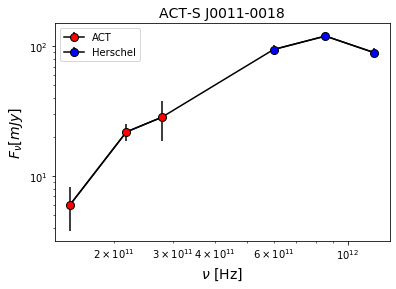

In [8]:
plt.plot(vf,frecs0T,"k")
plt.errorbar(v,frecs0[0],errf0[0],marker="o",markersize=8,markerfacecolor='red',c="k",label="ACT")
plt.errorbar(l,frecs0[1],errf0[1],marker="o",markersize=8,markerfacecolor='blue',c="k",label="Herschel")
plt.xlabel(r"$\nu$ [Hz]",fontsize=14)
plt.ylabel(r"$F_{\nu} [mJy]$",fontsize=14)
plt.title("{}".format(ID[0]),fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [9]:
def tau(z,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [10]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [11]:
(vf*un.Hz).to("GHz")

<Quantity [ 148.      ,  218.      ,  278.      ,  599.584916,  856.54988 ,
           1199.169832] GHz>

In [12]:
def modelSv(T,z,M_,d_,vf):
    v0=353*un.GHz
    b=2
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    Sv=S_.to("mJy")   
    return Sv

In [13]:
modelSv(50*un.K,3.3,5,2*un.kpc,100*un.Hz)

<Quantity 0. mJy>

In [27]:
def A(z,Tc,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    Tvariable=np.linspace(Tc,500,10000)
    print(Tvariable)
    integrales=[]
    for i in vf:
        #print("TAU:",tau(z,M_,d_,i))
        #print("PLANCK:",P(i,Tvariable,z))
        #print("SINGLE:",modelSv(Tvariable,z,M_,d_,i))
        integrales.append(scipy.integrate.trapz(modelSv(Tvariable,z,M_,d_,i)*Tvariable**-7))
    return integrales

In [15]:
A(3.3,45.9,9.45,2.9*un.kpc,vf*un.Hz) #1era galaxia ACT, con vf[i]

[ 45.9         45.94541454  45.99082908 ... 499.90917092 499.95458546
 500.        ]


[<Quantity 2.36630637e-09 mJy>,
 <Quantity 7.69563331e-09 mJy>,
 <Quantity 1.41482231e-08 mJy>,
 <Quantity 4.02295818e-08 mJy>,
 <Quantity 4.38048479e-08 mJy>,
 <Quantity 3.6363932e-08 mJy>]

In [34]:
def modelSobs(z,Tc,M_,d_,vf):
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    integral=A(z,Tc,M_,d_,vf)
    h=cte.h
    K=cte.k_B
    model=[]
    for j in range(6):
        model.append(6 * Tc**6 * integral[j]  + O * np.e**-tau(z,M_,d_,v0) * (2*h)/(c**2) * vf**3/(np.e**(h*vf/(K*TCMB))-1))
    return model

In [35]:
modelSobs(3.3,45.9,9.45,2.9*un.kpc,vf*un.Hz)

[ 45.9         45.94541454  45.99082908 ... 499.90917092 499.95458546
 500.        ]


[<Quantity [132.85475725, 132.84467252, 132.82292293, 132.77135071,
            132.76956339, 132.76950551] mJy>,
 <Quantity [431.87440605, 431.86432133, 431.84257174, 431.79099952,
            431.78921219, 431.78915432] mJy>,
 <Quantity [793.91846317, 793.90837845, 793.88662885, 793.83505663,
            793.83326931, 793.83321143] mJy>,
 <Quantity [2257.30001048, 2257.28992576, 2257.26817616, 2257.21660394,
            2257.21481662, 2257.21475875] mJy>,
 <Quantity [2457.9022316 , 2457.89214687, 2457.87039728, 2457.81882506,
            2457.81703774, 2457.81697986] mJy>,
 <Quantity [2040.40484761, 2040.39476289, 2040.3730133 , 2040.32144108,
            2040.31965375, 2040.31959588] mJy>]

ACT-S J0011-0018

In [ ]:
z0=3.3
M0_=9.45
d0_=2.9*un.kpc
Tc0=45.9*un.K

In [ ]:
modelSobs(z0,Tc0,x,b,M0_,d0_,vf*un.Hz,353*un.GHz)